<a href="https://colab.research.google.com/github/asanneh/CS109B_Final_Project_Group_35/blob/master/CS109B_Final_Project_Group_35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                 **COMPSCI 109B Final Project - Group 35**    
   **Project: Measuring the Shape and Brightness of Galaxies with Neural Networks**

              Alpha Sanneh, Brian Tao, Grace Greason, Evan Arnold


In [0]:
#install libraries we need here
# !pip install tf_keras_vis
# !pip install h5py

In [0]:
#import relevant libraries
# from __future__ import annotations
import numpy as np
import seaborn as sns
import os
import datetime
import h5py

import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (5,5)
%matplotlib inline

In [0]:
# %tensorflow_version 2.0.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D,\
                                    Dropout, Flatten, Activation, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, Precision, Recall, FalsePositives, \
                                     FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2

In [9]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.
print(tf.__version__)  # You should see a > 2.0.0 here!
# from tf_keras_vis.utils import print_gpus
# print_gpus()

2.2.0-rc2


In [0]:
# from google.colab import drive

In [10]:
file_path = '/content/drive/My Drive/'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

Working Directory: /content/drive/My Drive


In [0]:
 #reading data
f=h5py.File('Data.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()


In [15]:
image.shape, image_nonoise.shape

((18779, 64, 64), (18779, 64, 64))

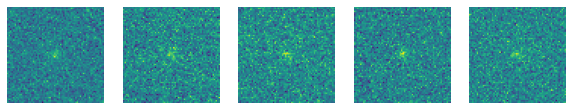

In [14]:
#plot a few of the images from image
fig, ax = plt.subplots(1,5, figsize=(10,10))
for i in range(5):
  ax = plt.subplot(1, 5, i+1)
  plt.imshow(np.squeeze(image[i]))
  ax.axis('off')

plt.show()

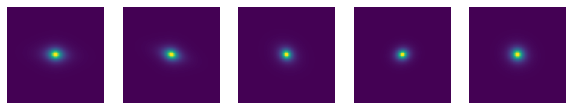

In [16]:
#images with no noise
fig, ax = plt.subplots(1,5, figsize=(10,10))
for i in range(5):
  ax = plt.subplot(1, 5, i+1)
  plt.imshow(np.squeeze(image_nonoise[i]))
  ax.axis('off')

plt.show()

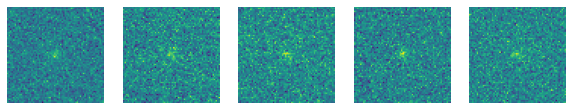

In [17]:
#images with noise
fig, ax = plt.subplots(1,5, figsize=(10,10))
for i in range(5):
  ax = plt.subplot(1, 5, i+1)
  plt.imshow(np.squeeze(image_withnoise[i]))
  ax.axis('off')

plt.show()